In [12]:
from colomoto.minibn import *
import pandas as pd
import bonesis

### Load synthetic Boolean network and associated configurations

# computing graph layout...


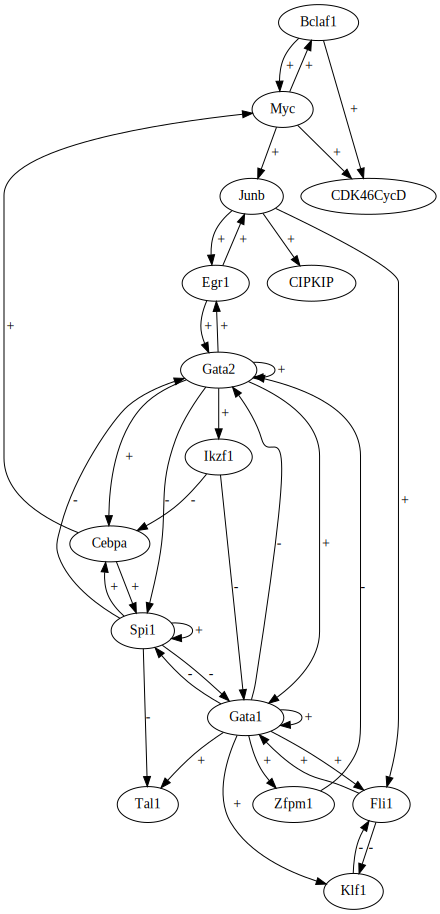

In [2]:
f = BooleanNetwork.load("boolean-network.bnet")
f_ig = f.influence_graph()
f_ig

# computing graph layout...


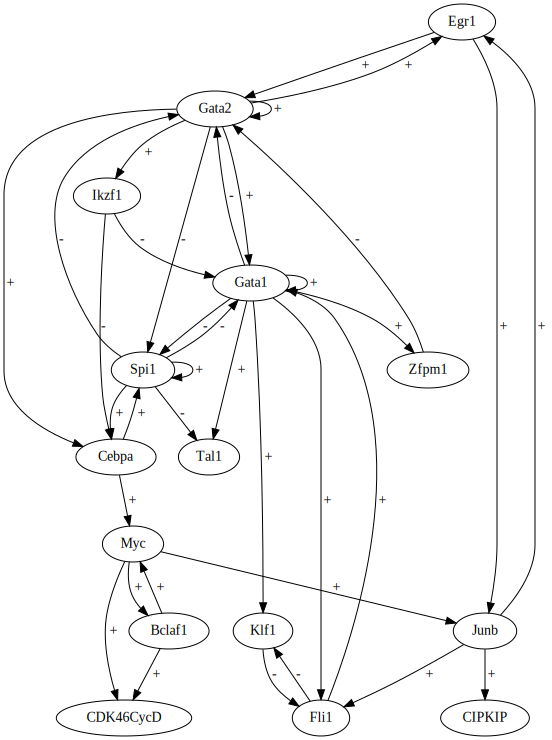

In [11]:
model = f.to_biolqm()
model = biolqm.to_ginsim(model)
net = bonesis.InfluenceGraph.from_ginsim(model, exact = True)

In [4]:
initial_state = f.zero()
for node in ["TF7", "TF6", "G7", "G8", "G9"]:
    initial_state[node] = 1
initial_state

{'G1': 0,
 'G2': 0,
 'G3': 0,
 'G4': 0,
 'G5': 0,
 'G6': 0,
 'G7': 1,
 'G8': 1,
 'G9': 1,
 'TF1': 0,
 'TF2': 0,
 'TF3': 0,
 'TF4': 0,
 'TF5': 0,
 'TF6': 1,
 'TF7': 1}

In [5]:
class PriorityDynamics(UpdateModeDynamics):
    def __call__(self, x):
        y = self.model(x)   # f(x)
        C = {a for a in self.nodes if y[a] != x[a]}
        genes = list(sorted(a for a in C if a.startswith("G")))
        if genes:
            z = x.copy()
            z[genes[0]] = y[genes[0]]
            yield z
            return
        for a in C:
            z = x.copy()
            z[a] = y[a]
            yield z

In [6]:
def node_to_dict(dyn, n):
    return {a: int(v) for (a,v) in zip(dyn.nodes, n)}

def make_labels(G):
    assert nx.is_tree(G)
    root = next(n for (n,ind) in G.in_degree() if ind == 0)
    G.nodes()[root]["label"] = "init" if G.out_degree(root) > 0 else "steady"
    ids = {"switch": 0, "steady": 0}
    def label_tree(root, begin):
        for n in G.successors(root):
            label_branch(n, begin)
    def label_branch(n, begin):
        global switch_id
        global steady_id
        if G.out_degree(root) != 1:
            assert NotImplementedError
        final_branch = len(list(nx.attracting_components(G.subgraph(nx.descendants(G, n))))) == 1
        final_key = "steady" if final_branch else "switch"
        ids[final_key] += 1
        dest = f"{final_key}{ids[final_key]}"
        i = 1
        while G.out_degree(n) == 1:
            label = f"{begin}_to_{dest}_{i}"
            G.nodes()[n]["label"] = label
            n = list(G.successors(n))[0]
            i += 1
        G.nodes()[n]["label"] = dest
        label_tree(n, dest)
    label_tree(root, "init")
    return G

def make_traj_df(f, initial_state):
    dyn = PriorityDynamics(f)
    stg = dyn.partial_dynamics(initial_state)
    make_labels(stg)
    return pd.DataFrame.from_dict({d["label"]: node_to_dict(dyn, n) for n, d in stg.nodes(data=True)}).T

In [7]:
data = make_traj_df(f, initial_state=initial_state)
data

,G1,G2,G3,G4,G5,G6,G7,G8,G9,TF1,TF2,TF3,TF4,TF5,TF6,TF7
init,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1
init_to_switch1_1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1
init_to_switch1_2,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
init_to_switch1_3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
init_to_switch1_4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
init_to_switch1_5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
init_to_switch1_6,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
switch1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1
switch1_to_steady1_1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1
switch1_to_steady2_1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1


In [8]:
data = make_traj_df(f, initial_state=initial_state)
#data = data.loc[['init']]
data = data.to_dict(orient = 'index')
data

{'init': {'G1': 0,
  'G2': 0,
  'G3': 0,
  'G4': 0,
  'G5': 0,
  'G6': 0,
  'G7': 1,
  'G8': 1,
  'G9': 1,
  'TF1': 0,
  'TF2': 0,
  'TF3': 0,
  'TF4': 0,
  'TF5': 0,
  'TF6': 1,
  'TF7': 1},
 'init_to_switch1_1': {'G1': 0,
  'G2': 0,
  'G3': 0,
  'G4': 0,
  'G5': 0,
  'G6': 0,
  'G7': 1,
  'G8': 1,
  'G9': 1,
  'TF1': 0,
  'TF2': 0,
  'TF3': 0,
  'TF4': 0,
  'TF5': 0,
  'TF6': 0,
  'TF7': 1},
 'init_to_switch1_2': {'G1': 0,
  'G2': 0,
  'G3': 0,
  'G4': 0,
  'G5': 0,
  'G6': 0,
  'G7': 0,
  'G8': 1,
  'G9': 1,
  'TF1': 0,
  'TF2': 0,
  'TF3': 0,
  'TF4': 0,
  'TF5': 0,
  'TF6': 0,
  'TF7': 1},
 'init_to_switch1_3': {'G1': 0,
  'G2': 0,
  'G3': 0,
  'G4': 0,
  'G5': 0,
  'G6': 0,
  'G7': 0,
  'G8': 0,
  'G9': 1,
  'TF1': 0,
  'TF2': 0,
  'TF3': 0,
  'TF4': 0,
  'TF5': 0,
  'TF6': 0,
  'TF7': 1},
 'init_to_switch1_4': {'G1': 0,
  'G2': 0,
  'G3': 0,
  'G4': 0,
  'G5': 0,
  'G6': 0,
  'G7': 0,
  'G8': 0,
  'G9': 0,
  'TF1': 0,
  'TF2': 0,
  'TF3': 0,
  'TF4': 0,
  'TF5': 0,
  'TF6': 0,
 

In [9]:
bo = bonesis.BoNesis(net,data)

In [14]:
# Set steady states
#bo.fixed(~bo.obs('steady1'))
#bo.fixed(~bo.obs('steady2'));

In [10]:
solutions = list(bo.boolean_networks())

Grounding...done in 0.0s


In [11]:
solutions

[G1 <- TF1
 G2 <- TF1
 G3 <- TF1
 G4 <- TF2
 G5 <- TF2
 G6 <- TF2
 G7 <- TF6
 G8 <- TF6
 G9 <- TF6
 TF1 <- !TF2&TF3
 TF2 <- !TF1|TF3
 TF3 <- TF4
 TF4 <- TF5
 TF5 <- !TF6
 TF6 <- !TF7
 TF7 <- 0,
 G1 <- TF1
 G2 <- TF1
 G3 <- TF1
 G4 <- TF2
 G5 <- TF2
 G6 <- TF2
 G7 <- TF6
 G8 <- TF6
 G9 <- TF6
 TF1 <- !TF2&TF3
 TF2 <- !TF1|TF3
 TF3 <- TF4
 TF4 <- TF5
 TF5 <- !TF6
 TF6 <- !TF7
 TF7 <- 1,
 G1 <- TF1
 G2 <- TF1
 G3 <- TF1
 G4 <- TF2
 G5 <- TF2
 G6 <- TF2
 G7 <- TF6
 G8 <- TF6
 G9 <- TF6
 TF1 <- !TF2|TF3
 TF2 <- !TF1|TF3
 TF3 <- TF4
 TF4 <- TF5
 TF5 <- !TF6
 TF6 <- !TF7
 TF7 <- 0,
 G1 <- TF1
 G2 <- TF1
 G3 <- TF1
 G4 <- TF2
 G5 <- TF2
 G6 <- TF2
 G7 <- TF6
 G8 <- TF6
 G9 <- TF6
 TF1 <- !TF2|TF3
 TF2 <- !TF1|TF3
 TF3 <- TF4
 TF4 <- TF5
 TF5 <- !TF6
 TF6 <- !TF7
 TF7 <- 1,
 G1 <- TF1
 G2 <- TF1
 G3 <- TF1
 G4 <- TF2
 G5 <- TF2
 G6 <- TF2
 G7 <- TF6
 G8 <- TF6
 G9 <- TF6
 TF1 <- !TF2&TF3
 TF2 <- !TF1&TF3
 TF3 <- TF4
 TF4 <- TF5
 TF5 <- !TF6
 TF6 <- !TF7
 TF7 <- 0,
 G1 <- TF1
 G2 <- TF1
 G3 <- T

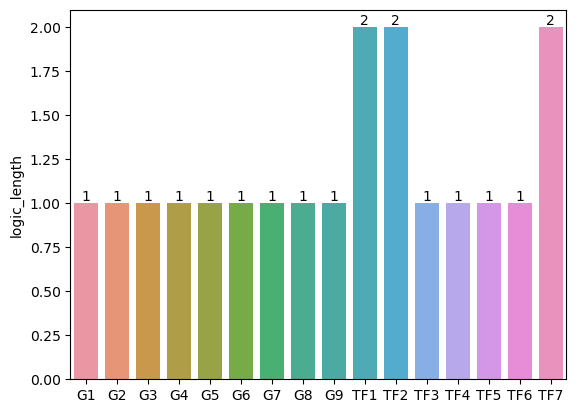

In [12]:
var_logic = pd.DataFrame(solutions)
var_logic_length = []
for i in var_logic.columns:
    num_logic = var_logic[i].value_counts().size
    var_logic_length.append(num_logic)
var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = var_logic.columns)

import seaborn as sns
ax = sns.barplot(x = var_logic_length.index, 
            y = var_logic_length.logic_length)
ax.bar_label(ax.containers[0], fontsize=10);

In [17]:
data = make_traj_df(f, initial_state=initial_state)
data.to_csv('/home/spankaew/Git/benchmark-dynamical-models/files/01_Ground_truth/toy_reprogramming_1/traj_df.csv')

In [14]:
from zipfile import ZipFile

exact_pkn = False
maxclause =  100
exclude_cyclic = False
bundle_prefix = "bundle-{}pkn{}-{}".format("exact" if exact_pkn else "any", maxclause,
        "nocyclic-" if exclude_cyclic else "")
limit = 100
threads = 10

# Function to write bonesis generated file to `.bnet`

def build_ensemble(bo, name, limit):
    zipfile = f"{bundle_prefix}{name}.zip"
    print(f"Building ensemble of size {limit} in {zipfile}")
    mylimit = 2*limit
    view = bo.diverse_boolean_networks(limit=mylimit, skip_supersets=False)
    with ZipFile(zipfile, "w") as bundle:
        n = 0
        for i, bn in enumerate(view):
            #if exclude_cyclic and has_cyclic(bn):
            #    print("HAS CYCLIC ATTRACTORS, IGNORING")
            #    continue
            with bundle.open(f"bn{i}.bnet", "w") as fp:
                fp.write(bn.source().encode())
            n += 1
            if n == limit:
                break

In [15]:
build_ensemble(bo, "toy_reprogramming", limit)

Building ensemble of size 100 in bundle-anypkn100-toy_reprogramming.zip
Grounding...done in 0.0s
Found 8 solutions in 0.1s (first in 0.0s; rate 0.0s)
